# Chainer MNIST tutorial

http://docs.chainer.org/en/latest/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

### Use model from Keras tutorial

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

In [2]:
import numpy as np
np.random.seed(123)  # for reproducibility

### Load MNIST dataset

In [3]:
import os
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.
import gzip

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [4]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [5]:
type(X_train)

numpy.ndarray

In [6]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


In [7]:
import math

def plotSet(X,Y,N=0):
    if N==0:
        N = len(X)
    total = N
    if (len(X) < N):
        N = len(X)
    if (len(Y) < N):
        N = len(Y)
    max_in_row = 25
    M = 1
    if N > max_in_row:
        M = int(math.ceil(N/max_in_row))
        N = max_in_row
    w = math.floor(1/N*1000)/1000    
    #w=0.1
    h = math.floor(1/(M) *1000)/1000
    #h=0.3
    #print N,M,w,h
    pad = 0
    fig = plt.figure(figsize=(N/1.5, M), dpi=120)    
    for j in range(M):
        for i in range(N):
            n = i+(j*N)+1 
            if n > total:
                break
            l = pad+(i+1)*(w+pad)
            b = pad+(j)*(h+pad)
            #print n,l,b,Y[n-1]
            #a = fig.add_axes([l, b, w, h])
            a = fig.add_subplot(M,N,n)
            a.imshow(X[n-1][0])
            a.axis('off')
            a.set_title(str(Y[n-1]),fontsize=10)

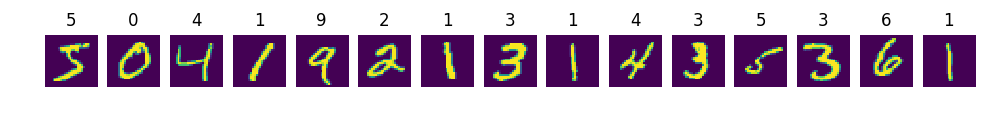

In [8]:
plotSet(X_train,y_train,15)

## Convert labels to 10 distinct class labels (one-hot)

In [9]:
print type(y_train[0])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print type(y_train[0])

<type 'numpy.uint8'>
<type 'numpy.int32'>


## Define model architecture

In [10]:
# Network definition Multi Layer Perceptron (MLP)
class MLP(chainer.Chain):

    def __init__(self, n_units=128, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [11]:
# Model definition
class SampleModel(chainer.Chain):

    def __init__(self):
        super(SampleModel, self).__init__(
            l1 = L.Convolution2D(None, 32, (3,3)),
            l2 = L.Convolution2D(None, 32, (3,3)),
            l6 = L.Linear(None, 128),
            l8 = L.Linear(None, 10),
        )

    def __call__(self, x):
        h = F.tanh(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.max_pooling_2d(h, (2,2))
        #h = F.flatten(h)
        h = F.reshape(h,(h.shape[0],h.shape[1]*h.shape[2]*h.shape[3]))
        #h = F.relu(self.l6(h5))
        h = F.dropout(h, 0.25)
        h = self.l8(h)
        h = F.relu(h)
        return h

In [12]:
from chainer.datasets import tuple_dataset
training_dataset = tuple_dataset.TupleDataset(X_train, y_train)
test_dataset = tuple_dataset.TupleDataset(X_test, y_test)

In [13]:
print type(training_dataset)
print len(training_dataset)

<class 'chainer.datasets.tuple_dataset.TupleDataset'>
60000


# Training parameters

In [14]:
batchsize = 64
epoch = 2
samples=1000

In [15]:
import sys

#model_class_name = "MLP"
model_class_name = "SampleModel"
model_class = getattr(sys.modules[__name__], model_class_name)
model = model_class()
print type(model)

model = L.Classifier(model, lossfun = F.softmax_cross_entropy)
optimizer = chainer.optimizers.AdaGrad(lr=0.01, eps=0.0005)
optimizer.setup(model)

<class '__main__.SampleModel'>


In [16]:
from chainer.training import extensions

train_iter = chainer.iterators.SerialIterator(training_dataset[:samples], batchsize)
test_iter = chainer.iterators.SerialIterator(test_dataset, batchsize,
                                                 repeat=False, shuffle=False)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=".")
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
    ['epoch',  'main/loss', 'validation/main/loss', 'main/accuracy','validation/main/accuracy', 'elapsed_time']))
# Save two plot images to the result dir
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy'],
                              'epoch', file_name='learning_curve.png'))

### Report extension

In [17]:
class Reporter(extensions.LogReport):
    
    train_acc = []
    train_loss = []
    test_acc = []
    
    def __call__(self, trainer):
        keys = self._keys
        observation = trainer.observation
        summary = self._summary
        #print "Debug info from Reporter"
        print observation
        
        ##
        ## TODO:
        ## Conver from Variable class to float
        self.train_acc.append(observation["main/accuracy"].data)
        self.train_loss.append(observation["main/loss"].data[0])
        self.test_acc.append(None)
        #print keys
        if keys is None:
            summary.add(observation)
        else:
            summary.add({k: observation[k] for k in keys if k in observation})

        if self._trigger(trainer):
            updater = trainer.updater
            print updater.epoch, updater.iteration, trainer.elapsed_time
            self.test_acc[-1] = observation["validation/main/accuracy"].data[0]
            
    def get_data(self):
        return {"train_acc":self.train_acc, "train_loss":self.train_loss, "test_acc":self.test_acc}

In [18]:
my_reporter = Reporter()
trainer.extend(my_reporter)


# Training

In [19]:
trainer.run()
data = my_reporter.get_data()
print data

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
{'main/loss': variable(2.273726224899292), 'main/accuracy': variable(0.171875)}


IndexError: too many indices for array

In [ ]:
def plot_loss_accuracy_org(train_loss, test_loss, train_acc, test_acc, train_points, validation_points) :    
    if train_points is None:
        train_points = np.arange(0,len(train_loss))        
    if validation_points is None:
        step = len(train_loss)/len(test_loss)
        print len(train_loss),"batches",len(test_loss),"epochs, step",step
        validation_points = np.arange(step,step*len(test_loss)+1,step)        
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(train_points, train_loss, 'r-',label= "loss_train",alpha=0.3)
    ax1.plot(validation_points, test_loss, 'r.-',label= "loss_test")
    ax2.plot(train_points, train_acc, 'b-',label= "acc_train",alpha=0.7)
    ax2.plot(validation_points, test_acc, 'b.-',label= "acc_test")
    ax1.set_ylim([0,2.5])
    ax1.set_xlabel('batch')
    ax1.set_ylabel('loss')
    ax2.set_ylabel('accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='center right')
    ax2.legend(loc='best')
    ax1.minorticks_on()
    ax1.grid(which="both")
    
def plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc) :    
    print len(train_acc)
    x = np.arange(0,len(train_acc))
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    if train_loss is not None:
        ax1.plot(x, train_loss, 'r-',label= "loss_train",alpha=0.3)
    if test_loss is not None:
        ax1.plot(x, test_loss, 'r.-',label= "loss_test")
    if train_acc is not None:
        ax2.plot(x, train_acc, 'b-',label= "acc_train",alpha=0.7)
    if test_acc is not None:
        ax2.plot(x, test_acc, 'b.-',label= "acc_test")
    ax1.set_ylim([0,2.5])
    ax1.set_xlabel('batch')
    ax1.set_ylabel('loss')
    ax2.set_ylabel('accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='center right')
    ax2.legend(loc='best')
    ax1.minorticks_on()
    ax1.grid(which="both")

In [ ]:
print type(data["train_loss"])
train_loss = np.asarray(data["train_loss"])
#train_loss = train_loss.astype(np.float32)
print type(train_loss[0])
plot_loss_accuracy(data["train_loss"], None, data["train_acc"], data["test_acc"])

# Test predictions

In [ ]:
def decodeNum(x):
    i = []
    for xi in x:
        ni = np.argmax(xi)
        i.append(ni)
    return i

In [ ]:
# Pick random indexes
test_indexes = np.random.randint(0,y_test.shape[0], batchsize)
x = X_test[test_indexes]
t = y_test[test_indexes]

# Predictions for random elements
y = model.predictor(x)
y = y.data
# y has predictions as probabilities
h = np.asarray(decodeNum(y))
# h has predictions as numbers

# Find incorrect predictions
errors = []
for i in range(len(h)):
    if h[i] != t[i]:        
        errors.append(i)
print "Have",len(errors),"errors"
# errors has indexes of incorrect redictions
for i in errors:
    print h[i],"≠", t[i]

# plot images and predictions (incorrect)
if len(errors) > 0:
    plotSet(x[errors],h[errors])

    # Plot probabilities
    y_err = y[errors]
    for i in range(len(y_err)):
        fig = plt.figure()
        plt.bar(range(len(y_err[i])), y_err[i])